# __DICODING MACHINE LEARNING__
Nama : Fahmy Rosyadi <br>
Asal Instansi : Politeknik Negeri Jember
<br>
Proyek : Temperature Prediction Time Series

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split


## Load Dataset CSV dari Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset : https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByMajorCity.csv

In [3]:
df = pd.read_csv('/content/drive/MyDrive/DatasetCollab/TimeSeries/GlobalLandTemperaturesByMajorCity.csv')
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E


## Lakukan Preprocessing Data

In [4]:
df.drop(['City','Latitude','Longitude'], axis=1, inplace=True)
display(df)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1849-01-01,26.704,1.435,Côte D'Ivoire
1,1849-02-01,27.434,1.362,Côte D'Ivoire
2,1849-03-01,28.101,1.612,Côte D'Ivoire
3,1849-04-01,26.140,1.387,Côte D'Ivoire
4,1849-05-01,25.427,1.200,Côte D'Ivoire
...,...,...,...,...
239172,2013-05-01,18.979,0.807,China
239173,2013-06-01,23.522,0.647,China
239174,2013-07-01,25.251,1.042,China
239175,2013-08-01,24.528,0.840,China


In [5]:
df = df.loc[df['Country'].isin(['China'])]
df

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
47038,1820-08-01,19.674,2.283,China
47039,1820-09-01,14.841,1.792,China
47040,1820-10-01,4.825,1.911,China
47041,1820-11-01,-5.807,2.309,China
47042,1820-12-01,-15.398,2.601,China
...,...,...,...,...
239172,2013-05-01,18.979,0.807,China
239173,2013-06-01,23.522,0.647,China
239174,2013-07-01,25.251,1.042,China
239175,2013-08-01,24.528,0.840,China


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35444 entries, 47038 to 239176
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             35444 non-null  object 
 1   AverageTemperature             34952 non-null  float64
 2   AverageTemperatureUncertainty  34952 non-null  float64
 3   Country                        35444 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1.4+ MB


In [8]:
df['dt'] = pd.to_datetime(df['dt'], errors='coerce')
get_data = (df['dt'] > '1900-01-01') & (df['dt'] <= '2013-09-01')
df.loc[get_data]

df = df.loc[get_data].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21824 entries, 47992 to 239176
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             21824 non-null  datetime64[ns]
 1   AverageTemperature             21808 non-null  float64       
 2   AverageTemperatureUncertainty  21808 non-null  float64       
 3   Country                        21824 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 852.5+ KB


In [9]:
df.drop(['Country'], axis=1, inplace=True)
df.reset_index(drop=True)

,dt,AverageTemperature,AverageTemperatureUncertainty
0,1900-02-01,-11.314,0.912
1,1900-03-01,-2.830,1.422
2,1900-04-01,6.698,0.847
3,1900-05-01,14.996,1.048
4,1900-06-01,20.378,1.451
...,...,...,...
21819,2013-05-01,18.979,0.807
21820,2013-06-01,23.522,0.647
21821,2013-07-01,25.251,1.042
21822,2013-08-01,24.528,0.840


In [10]:
df.isnull().sum()

dt                                0
AverageTemperature               16
AverageTemperatureUncertainty    16
dtype: int64

In [11]:
df['dt'].head()
df['AverageTemperature'].fillna(df['AverageTemperature'].mean(), inplace=True)
df['AverageTemperatureUncertainty'].fillna(df['AverageTemperatureUncertainty'].mean(), inplace=True)
df = df[['dt','AverageTemperature', 'AverageTemperatureUncertainty']]
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty
47992,1900-02-01,-11.314,0.912
47993,1900-03-01,-2.830,1.422
47994,1900-04-01,6.698,0.847
47995,1900-05-01,14.996,1.048
47996,1900-06-01,20.378,1.451


In [13]:
df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
dtype: int64

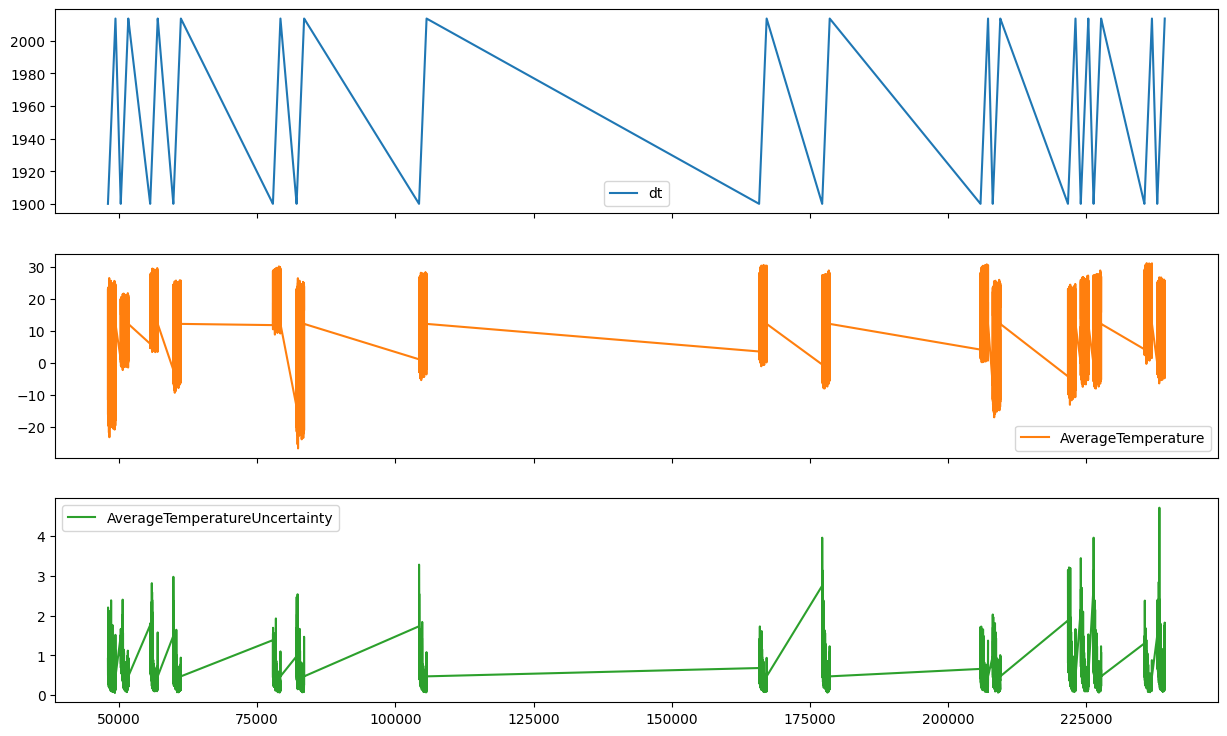

In [14]:
df_plot = df
df_plot[df_plot.columns.to_list()].plot(subplots=True, figsize=(15, 9))
plt.show()

In [15]:
dates = df['dt'].values
temp = df['AverageTemperature'].values

Text(0.5, 0, 'Datetime')

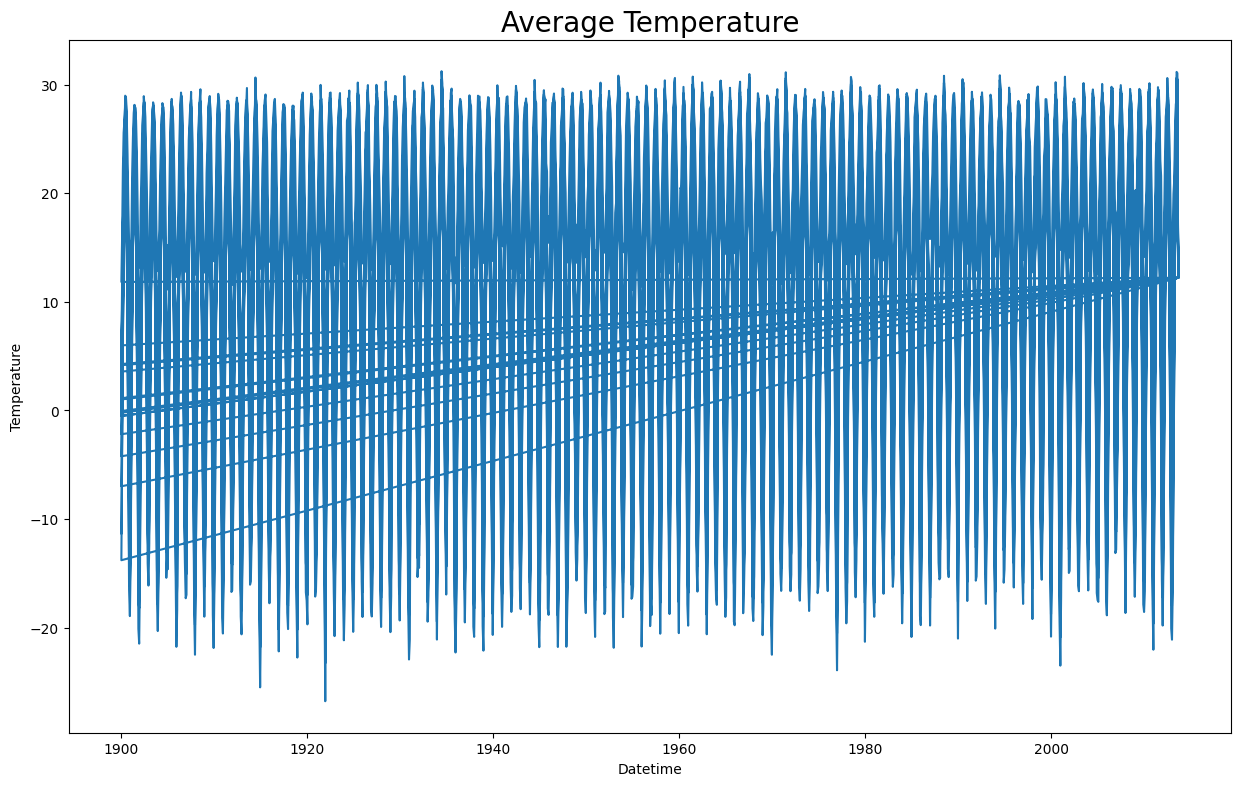

In [16]:
dates = np.array(dates)
temp = np.array(temp)

plt.figure(figsize=(15,9))
plt.plot(dates, temp)

plt.title('Average Temperature', fontsize = 20)
plt.ylabel('Temperature')
plt.xlabel('Datetime')

In [17]:
df.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
dtype: object

## Split data train dan testing

In [18]:
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, random_state = 0 , shuffle=False)
print('Total Data Train : ',len(x_train),'Total Data Test : ', len(x_test))

Total Data Train :  17459 Total Data Test :  4365


In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

## Pelatihan Model

In [40]:
tf.keras.backend.set_floatx('float64')
w_z = 64
b_z = 250
s_b = 1000
train_set = windowed_dataset(x_train, window_size=w_z, batch_size=b_z, shuffle_buffer=s_b)
val_set = windowed_dataset(x_test, window_size=w_z, batch_size=b_z, shuffle_buffer=s_b)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 32)          192       
                                                                 
 bidirectional_8 (Bidirecti  (None, None, 120)         44640     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 120)               86880     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 30)                3630      
                                                                 
 dense_13 (Dense)            (None, 10)                310       
                                                                 
 dense_14 (Dense)            (None, 1)                

In [42]:
Mae = (df['AverageTemperature'].max() - df['AverageTemperature'].min()) * 10/100
print(Mae)

5.8004999999999995


In [43]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<5 and logs.get('val_mae')<5):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [44]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=10, validation_data = val_set, callbacks=[callbacks])

Epoch 1/10
70/70 [==============================] - 142s 2s/step - loss: 6.9437 - mae: 7.4248 - val_loss: 2.5923 - val_mae: 3.0553
Epoch 2/10
70/70 [==============================] - ETA: 0s - loss: 2.2418 - mae: 2.6908
MAE dari model < 10% skala data
70/70 [==============================] - 125s 2s/step - loss: 2.2418 - mae: 2.6908 - val_loss: 1.8323 - val_mae: 2.2855


## Evaluasi Model

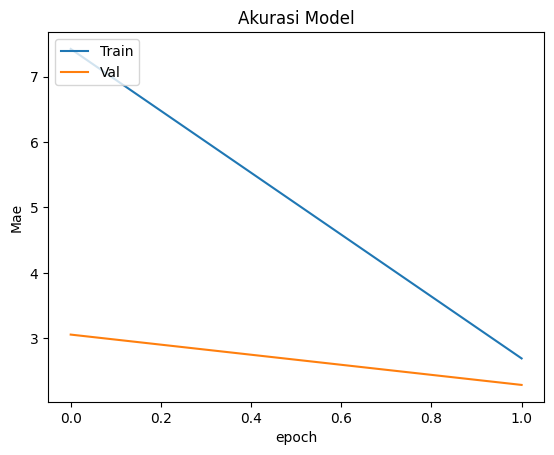

In [47]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


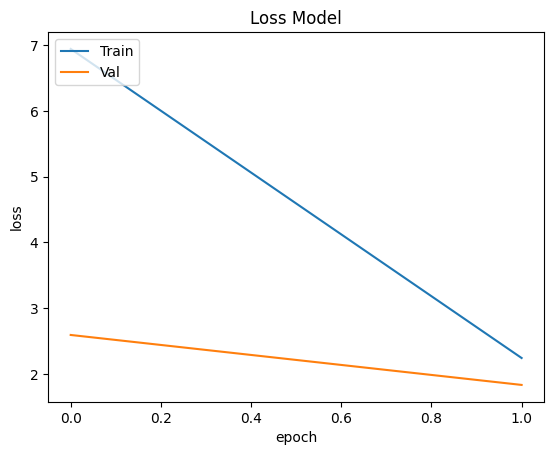

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()